<a href="https://colab.research.google.com/github/BolachinhaAmericana/BigDataProject/blob/main/colab-code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capa

<img src="./images/logo-ESTB.png"
     alt="ESTBarreiro"
     style="float: left; margin-right: 10px;" />
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>
- ESTBarreiro - IPS Bioinformatica - Janeiro 2023
- Ano 3, semestre 1
- UC: Big Data
- Duarte Valente - 202000053
- Guilherme Sá   - 202000201
- Docentes: Raquel Barreira e António Gonçalves

# Introduçao

## Objetivos deste trabalho:
- Este projeto tem como principal objetivo dar-nos a conhecer e utilizar o Spark no contexto de Machine Leaning.
- Aqui vamos usar tecnicas de machine learning para analisar uma grande quantidade de dados e prever resultados para um determinado problema, assim como usar o spark para ler e apresentar resultados relativamente aos modelos de ML.
- Tudo isto tem o intuito de simular um ambiente de grande escala e alta performance.
## Introducao ao dataset utilizado
- Nome: SparkML - Credit Card Fraud - KMA
- Nome do dataset: creditcard.csv
- O nosso dataset pode ser encontrado [aqui](https://www.kaggle.com/code/ukveteran/sparkml-credit-card-fraud-jma/data)
- Este conjunto de dados é, nada mais nada menos que informaçoes sobre transaçoes de credit cards.
- Com isto, o objetivo do trabalho será prever, de acordo com as caracteristicas de uma transaçao, se a mesma é ou nao fraude.








# Projeto

## Instalar os packaged necessarios

In [2]:
%pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Spark Session imports
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
# Spark ML imports
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
# other imports 
import matplotlib as plt

## Criar Ambiente do Spark
- Aqui estamos a criar um ambiente de spark com o nome de CreditcardPrediction e com o computador master
- Quando se trabalha com o Spark temos de criar uma Sessao SparkSession para gerir todas as configuraçoes do nosso ambienter de spark.

In [4]:
conf= SparkConf().setAppName('CreditCardPrediction').setMaster('local[*]')
sc= SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)
spark

## Importar os dados (creditcard.csv)

### Importar os dados pelo google drive

Temos de ter o dataset ou no mesmo path ou ajustar o mesmo manualmente.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df = spark.read.csv("../content/drive/MyDrive/Colab Notebooks/BigData/Datasets/creditcard.csv", header=True, inferSchema=True)

## Visualisar dados
Vamos simplesmente observar os dados, com o pandas, com o spark e ver a dimanesao e disparidade dos dados

In [10]:
df.toPandas().head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Descriçao das caracteristicas do Dataset:
- Time: Numero de segundos passados entre a transaçao em causa e a primeira transaçao do dataset.
- V (1-28): Sao dados dados que foram alterados propositadamente para que informaçoes dos utilizadores fossem protegidas.
- Amount: Quantidade de dinheiro transferido
- Class: Verificaçao se a transaçao era ou nao fraude, 1= fraude e 0 para todos os outros casos.

In [11]:
df.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

In [12]:
counts = df.groupBy("Class").count()
counts.show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



In [13]:
print(f"Numero de Linhas: {df.count()}")
print(f"Numero de Colunas:{len(df.columns)}")
print("Esquema do DataFrame:")
df.printSchema()

Numero de Linhas: 284807
Numero de Colunas:31
Esquema do DataFrame:
root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullabl

- Aqui Conseguimos ver que o nosso dataset tem 284807 items e 31 caracteristicas, assim como podemos verificar que todas as caracteristicas podem aceitar valores nulos.

## Sumarizaçao dos Dados
- Teem uma dimensao de 284807 entidades e 31 caracteristicas.
- Teem uma grande amostra de casos de nao-fraude (492) e muito poucos de fraude (284315), o que pode levar a problemas na detecao de fraunde por nao ter amostra suficiente

## Gráficos:

### graficos para todas as caracteristicas e a sua distribuiçao

In [14]:
num_cols = [i for i in df.columns]
df_num = df.select(num_cols)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdac3cf3ee0>,
      dtype=object)

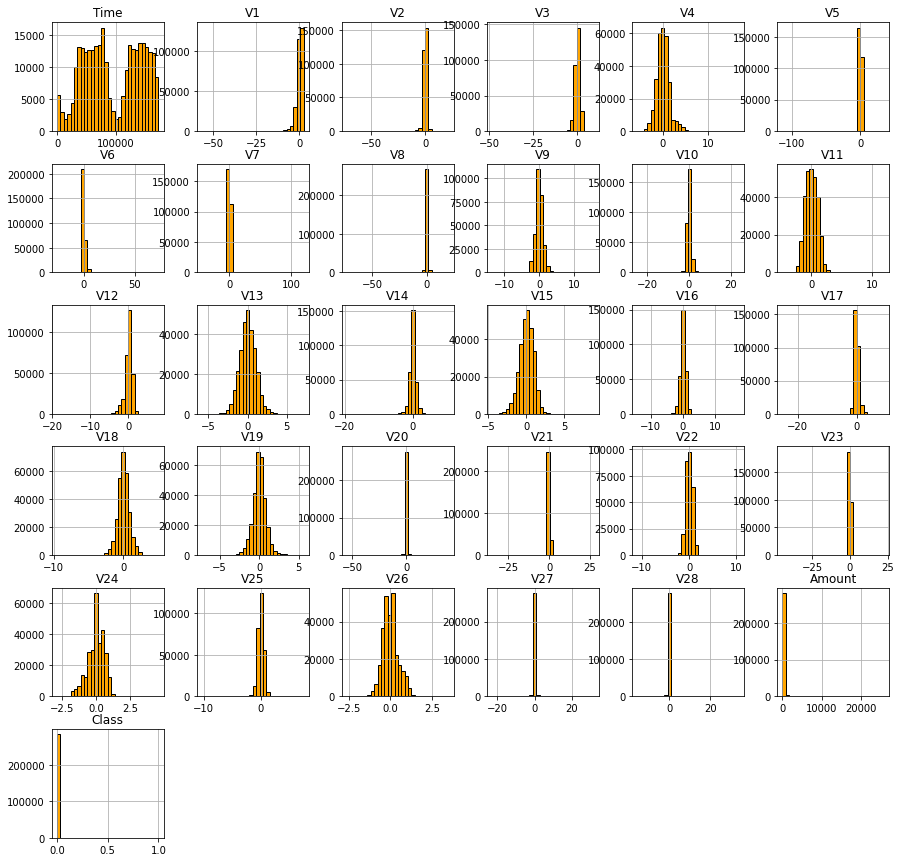

In [17]:
df_num.toPandas().hist(figsize=[15,15],bins=30, color='orange', histtype='bar', ec='black')


#### Breve explicaçao dos graficos:
- Estes histogramas estao a ser apresentados com o objetivo de mostrar a distribuiçao dos valores pelo count de um determinado valor.
#### Breve analise dos graficos:
- Time - Nao ha muito que se possa retirar deste histograma, apenas que tem valores significativos a correr ao longo de todo o percurso. Significa que nao houve um tempo relevante sem haver nenhuma transaçao
- Vs - Nao conseguimos tirar informaçao relevante por nao se saber a natureza dos dados.
- Amount - Conseguimos verificar que a grande maioria das transaçoes está concentrada em valores de até 5000
- Class - Conseguimos verificar que existe uma concentraçao muito maior no valor 0, correspondente a "Nao é fraude". Isto é bom no entanto por haver uma grande disparidade na quantidade de dados entre valores positivos e negativos poderá levar a problemas na nossa previsao de resultados com machine learning.

## Tratamento dos dados

#### Vamos começar por verificar a existencia de valores nulos.

In [18]:
null_values = []
for col in df.columns:
    null_values.append((col, df.filter(df[col].isNull()).count()))

In [ ]:
col_count = 0
null_col_count = 0
for col, value in null_values:
    col_count = col_count + 1
    if value == 0:
        null_col_count = null_col_count + 1
    else:
        print(f"{col} : {value} missing values")
if col_count == null_col_count:
    print("Nao ha valores nulos")

### Tranformaçao de dados

- Aqui vamos pegar em todas as caracteristicas dos dados exceto a variavel target e criar um objeto vetor para o item. Vamos fazer isto para obter um resultado de: 
- [Caracteristica 1 | C2 | C3 | C4 | ... | Class] para:
- [C1 | Class]

In [20]:
cols = df.columns
cols.remove('Class')

Primeiro adicionamos todas as colunas a uma variavel e removemos apenas a ultima coluna.

In [21]:
assembler = VectorAssembler(inputCols= cols, outputCol= 'features')

Em seguida fomos "colar" as caracteristicas dentro desta nova variavel e dar o nome ao conjunto de "features"

In [22]:
df = assembler.transform(df)

Agora vamos visualizar os dados depois de serem tratados, e vamos poder observar que de 30 passamos a ter apenas 2 colunas e vamos usar a coluna das features para prever a da class, uma vez que a features nao e nada mais nada menos que todas as outras 29 caracteristicas juntas.

In [23]:
df = df.select(['features', 'Class'])
df.show(5)

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[0.0,-1.359807133...|    0|
|[0.0,1.1918571113...|    0|
|[1.0,-1.358354061...|    0|
|[1.0,-0.966271711...|    0|
|[2.0,-1.158233093...|    0|
+--------------------+-----+
only showing top 5 rows



## Aplicar Modelos de Machine Learning
Neste trabalho vao ser usados 2 modelos de machine learning, a Regressao logistica e o random forest. Estes modelos foram escolhidos por serem bons candidatos a tratar de classificacao binaria, que era o caso do nosso dataset.

### Defenir Test/Split
Neste caso vamos fazer o split a 70% dos dados para treino e os restantes 30% para teste

In [24]:
training, testing= df.randomSplit([0.7, 0.3])

### Modelo - Regressao Logistica

#### treino e teste do modelo

In [25]:
lr = LogisticRegression(labelCol='Class', featuresCol='features')
model= lr.fit(training) # fit dos dados de treino
predictions = model.transform(testing) # teste do modelo com os dados de teste

#### Verificar resultados do teste

In [26]:
evaluator = BinaryClassificationEvaluator(labelCol='Class', rawPredictionCol='rawPrediction')
accuracy = evaluator.evaluate(predictions)
accuracy

0.9799958174337905

Com isto temos um modelo de previsao a usar regressao logistica em que obtivemos uma precisao de aproximadamente 98%

#### tabela com a previsao

In [27]:
predictions.toPandas()

,features,Class,rawPrediction,probability,prediction
0,"[1.0, -1.35835406159823, -1.34016307473609, 1....",0,"[7.264101203439944, -7.264101203439944]","[0.9993002596279171, 0.0006997403720828688]",0.0
1,"[10.0, 1.249998742053, -1.22163680921816, 0.38...",0,"[9.526695680099534, -9.526695680099534]","[0.9999271252655704, 7.287473442962877e-05]",0.0
2,"[12.0, -0.752417042956605, 0.345485415344747, ...",0,"[9.07650178613821, -9.07650178613821]","[0.9998856922402831, 0.00011430775971688067]",0.0
3,"[15.0, 1.4929359769862, -1.02934573189487, 0.4...",0,"[9.612597467750101, -9.612597467750101]","[0.9999331235951852, 6.68764048148418e-05]",0.0
4,"[18.0, 0.247491127783665, 0.277665627353681, 1...",0,"[6.534195109377805, -6.534195109377805]","[0.9985492098688424, 0.0014507901311575644]",0.0
...,...,...,...,...,...
85269,"[172777.0, -1.26658018751073, -0.4004612550902...",0,"[9.025225480789098, -9.025225480789098]","[0.9998796788102043, 0.00012032118979565798]",0.0
85270,"[172785.0, 0.120316379951799, 0.93100513345655...",0,"[9.418267813240337, -9.418267813240337]","[0.9999187800000676, 8.121999993238038e-05]",0.0
85271,"[172786.0, -11.8811178854323, 10.0717849710003...",0,"[22.087943506216128, -22.087943506216128]","[0.999999999744537, 2.554629841000633e-10]",0.0
85272,"[172788.0, -0.240440049680947, 0.5304825131188...",0,"[7.565795823894952, -7.565795823894952]","[0.9994824029710909, 0.0005175970289090781]",0.0


### Modelo - Random forest

#### treino e teste do modelo
Neste caso, estamos a fazer um modelo com uma profuncidade maxima de 5 para evitar overfitting.

In [28]:
rf = RandomForestClassifier(labelCol="Class", featuresCol="features", maxDepth= 5)
model = rf.fit(training)
predictions = model.transform(testing) # teste do modelo com os dados de teste

#### verificar resultados do teste

In [29]:
evaluator = BinaryClassificationEvaluator(labelCol='Class', rawPredictionCol='rawPrediction')
accuracy = evaluator.evaluate(predictions)
accuracy

0.9694445409084596

Com isto temos um modelo de previsao a usar o Random Forest em que obtivemos uma precisao de aproximadamente 96%

#### tabela com a previsao

In [30]:
predictions.toPandas()

,features,Class,rawPrediction,probability,prediction
0,"[1.0, -1.35835406159823, -1.34016307473609, 1....",0,"[19.99165997143452, 0.0083400285654825]","[0.999582998571726, 0.000417001428274125]",0.0
1,"[10.0, 1.249998742053, -1.22163680921816, 0.38...",0,"[19.993914866764996, 0.006085133235003325]","[0.9996957433382498, 0.00030425666175016626]",0.0
2,"[12.0, -0.752417042956605, 0.345485415344747, ...",0,"[19.993914866764996, 0.006085133235003325]","[0.9996957433382498, 0.00030425666175016626]",0.0
3,"[15.0, 1.4929359769862, -1.02934573189487, 0.4...",0,"[19.993914866764996, 0.006085133235003325]","[0.9996957433382498, 0.00030425666175016626]",0.0
4,"[18.0, 0.247491127783665, 0.277665627353681, 1...",0,"[19.988459752871698, 0.011540247128301647]","[0.999422987643585, 0.0005770123564150824]",0.0
...,...,...,...,...,...
85269,"[172777.0, -1.26658018751073, -0.4004612550902...",0,"[19.992116806301, 0.007883193698998897]","[0.9996058403150501, 0.0003941596849499449]",0.0
85270,"[172785.0, 0.120316379951799, 0.93100513345655...",0,"[19.993914866764996, 0.006085133235003325]","[0.9996957433382498, 0.00030425666175016626]",0.0
85271,"[172786.0, -11.8811178854323, 10.0717849710003...",0,"[19.98238526799699, 0.017614732003010485]","[0.9991192633998495, 0.0008807366001505242]",0.0
85272,"[172788.0, -0.240440049680947, 0.5304825131188...",0,"[19.993914866764996, 0.006085133235003325]","[0.9996957433382498, 0.00030425666175016626]",0.0


# Conclusao 
Neste trabalho foi utilizado o PySpark para carregar, processar e analisar um dataset. Em seguida foi utilizado o MLlib para treinar e avaliar modelos de machine learning. Como modelos foram usados a regressao logistica e o Random Forest. Ambos os modelos optiveram um desempenho que consideramos adequado na previsao de se havia fraude ou nao na transacao. Estamos satisfeitos com os resultados obtidos. Podendo até dizer que correu melhor que o esperado dada a disparidade entre os dados da variavel target.